<a href="https://colab.research.google.com/github/hr1588/dacon/blob/main/%EC%98%A4%EB%8A%98%EC%9D%98_%ED%8C%8C%EC%9D%B4%EC%8D%AC_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 교차검증과 LGBM 모델을 활용한 와인 품질 분류

## 데이터 로드 및 라이브러리 불러오기

In [ ]:
!wget 'https://bit.ly/3i4n1QB'

import zipfile
with zipfile.ZipFile('3i4n1QB', 'r') as existing_zip:
    existing_zip.extractall('data')

In [2]:
import pandas as pd

In [13]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5497 entries, 0 to 5496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5497 non-null   int64  
 1   quality               5497 non-null   int64  
 2   fixed acidity         5497 non-null   float64
 3   volatile acidity      5497 non-null   float64
 4   citric acid           5497 non-null   float64
 5   residual sugar        5497 non-null   float64
 6   chlorides             5497 non-null   float64
 7   free sulfur dioxide   5497 non-null   float64
 8   total sulfur dioxide  5497 non-null   float64
 9   density               5497 non-null   float64
 10  pH                    5497 non-null   float64
 11  sulphates             5497 non-null   float64
 12  alcohol               5497 non-null   float64
 13  type                  5497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 601.4+ KB


In [6]:
train.shape

(5497, 14)

In [10]:
train.head()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


In [60]:
train.isnull().sum() # 결측치 확인

index                   0
quality                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 1000 non-null   int64  
 1   fixed acidity         1000 non-null   float64
 2   volatile acidity      1000 non-null   float64
 3   citric acid           1000 non-null   float64
 4   residual sugar        1000 non-null   float64
 5   chlorides             1000 non-null   float64
 6   free sulfur dioxide   1000 non-null   float64
 7   total sulfur dioxide  1000 non-null   float64
 8   density               1000 non-null   float64
 9   pH                    1000 non-null   float64
 10  sulphates             1000 non-null   float64
 11  alcohol               1000 non-null   float64
 12  type                  1000 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 101.7+ KB


In [15]:
test.isnull().sum()

index                   0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64

In [16]:
train.describe() # 통계치 확인

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000,5497.000000
mean,2748.000000,5.818992,7.210115,0.338163,0.318543,5.438075,0.055808,30.417682,115.566491,0.994673,3.219502,0.530524,10.504918
std,1586.991546,0.870311,1.287579,0.163224,0.145104,4.756676,0.034653,17.673881,56.288223,0.003014,0.160713,0.149396,1.194524
min,0.000000,3.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000
25%,1374.000000,5.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,78.000000,0.992300,3.110000,0.430000,9.500000
50%,2748.000000,6.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994800,3.210000,0.510000,10.300000
75%,4122.000000,6.000000,7.700000,0.400000,0.390000,8.100000,0.064000,41.000000,155.000000,0.996930,3.320000,0.600000,11.300000
max,5496.000000,9.000000,15.900000,1.580000,1.660000,65.800000,0.610000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [17]:
test.describe()

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,7.243850,0.347930,0.319130,5.47160,0.057275,31.117000,116.723500,0.994825,3.213000,0.535360,10.419693
std,288.819436,1.344372,0.172043,0.146561,4.76628,0.037048,18.156527,57.808145,0.002912,0.161165,0.145525,1.180694
min,0.000000,4.200000,0.080000,0.000000,0.70000,0.014000,1.000000,7.000000,0.988150,2.720000,0.230000,8.400000
25%,249.750000,6.400000,0.230000,0.240000,1.80000,0.039000,17.750000,76.750000,0.992448,3.100000,0.437500,9.500000
50%,499.500000,7.000000,0.300000,0.300000,2.90000,0.048000,29.000000,118.500000,0.995130,3.200000,0.510000,10.200000
75%,749.250000,7.700000,0.410000,0.392500,8.20000,0.067250,42.000000,156.000000,0.997060,3.312500,0.620000,11.200000
max,999.000000,15.600000,1.240000,0.810000,22.60000,0.611000,122.500000,289.000000,1.003150,3.780000,1.310000,14.000000


# 시각화

In [ ]:
# 시각화를 위한 한글 폰트 다운로드

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [23]:
# 필요한 라이브러리 로드

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 쥬피터노트에서 결과를 출력하도록 설정
%matplotlib inline

# 글꼴 설정
plt.rc('font', family='NanumBarunGothic')

# 마이너스 기호 출력
plt.rc('axes', unicode_minus=False)

# 분석에 문제가 없는 경고 메세지는 숨긴다.
import warnings
warnings.filterwarnings('ignore')

In [21]:
traindata = train.copy()

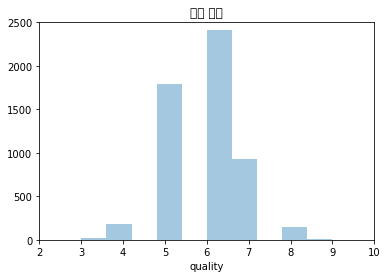

In [28]:
# 타깃 변수(와인 품질) 분포 시각화
sns.distplot(traindata['quality'], kde=False, bins=10)
plt.axis([2, 10, 0, 2500]) # [x 축 최솟값, x 축 최댓값, y 축 최솟값, y 축 최댓값]
plt.title("와인 품질") # 그래프 제목 지정
plt.show() # 그래프 그리기

- kde: 그래프에 선을 출력할지 여부
- bins: 출력할 막대그래프 갯수

## 이상치 탐지 후 제거

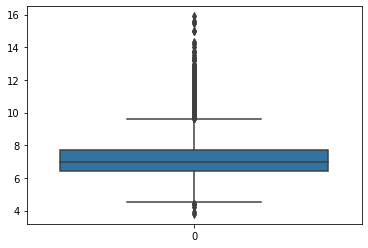

In [31]:
sns.boxplot(data=train['fixed acidity'])

- IQR을 활용해서 이상치 제거

In [32]:
import numpy as np
quantile_25 = np.quantile(train['fixed acidity'], 0.25) # 1 사분위수
quantile_75 = np.quantile(train['fixed acidity'], 0.75) # 3 사분위수
IQR = quantile_75 - quantile_25 # 사분위수 범위
minimum = quantile_25 - 1.5 * IQR # 최솟값
maximum = quantile_75 + 1.5 * IQR # 최댓값
train2 = train[(minimum <= train['fixed acidity']) & (train['fixed acidity'] <= maximum)] # 이상치를 제외한 값을 따로 저장
train2.shape

(5203, 14)

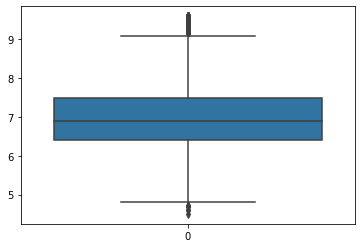

In [33]:
sns.boxplot(data = train2['fixed acidity'])

In [34]:
train.shape[0] - train2.shape[0] # 제거한 이상치 개수 확인

294

## 정규화


In [35]:
train2.describe() # 이상치를 제거한 데이터셋 활용

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5203.000000,5203.000000,5203.000000,5203.000000,5203.000000,5203.000000,5203.000000,5203.000000,5203.000000,5203.000000,5203.000000,5203.000000,5203.000000
mean,2753.771670,5.821065,7.004132,0.332852,0.309366,5.573131,0.054088,31.337113,119.578897,0.994472,3.222862,0.521893,10.504133
std,1587.326459,0.868565,0.906623,0.162106,0.140360,4.828254,0.033831,17.536054,54.483795,0.002926,0.161715,0.143725,1.201914
min,0.000000,3.000000,4.500000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000
25%,1380.500000,5.000000,6.400000,0.220000,0.240000,1.800000,0.037000,18.000000,86.000000,0.992160,3.110000,0.430000,9.500000
50%,2754.000000,6.000000,6.900000,0.290000,0.300000,3.300000,0.046000,30.000000,121.000000,0.994600,3.210000,0.500000,10.300000
75%,4129.500000,6.000000,7.500000,0.390000,0.380000,8.300000,0.060000,42.000000,157.000000,0.996660,3.330000,0.590000,11.300000
max,5496.000000,9.000000,9.600000,1.580000,1.660000,65.800000,0.610000,289.000000,440.000000,1.038980,4.010000,2.000000,14.200000


In [106]:
from sklearn.preprocessing import MinMaxScaler # Min Max Scailing 기법 사용
scaler = MinMaxScaler()
scaler.fit(train2[['fixed acidity']])
train2['Scaled fixed acidity'] = scaler.transform(train2[['fixed acidity']])
test['Scaled fixed acidity'] = scaler.transform(test[['fixed acidity']])

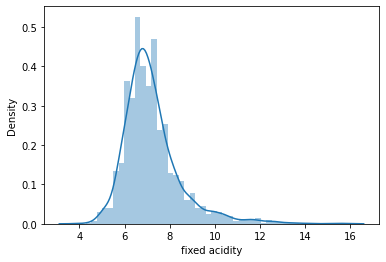

In [40]:
sns.distplot(train['fixed acidity'])

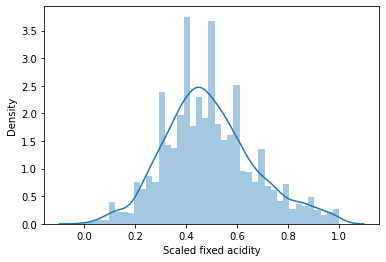

In [39]:
sns.distplot(train2['Scaled fixed acidity'])

- Min Max Scaling은 "이상치"에 민감함 
- 이상치를 처리하지 않은 경우 상대적으로 굉장히 큰 값이나, 작은 값을 1이나 0으로 만들기 때문에 문제가 발생할 수 있음

## One-Hot Encoding

In [77]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(train2[['type']])
onehot = encoder.transform(train2[['type']])
onehot = onehot.toarray()
onehot = pd.DataFrame(onehot)
onehot.columns = encoder.get_feature_names()
onehot = pd.concat([train2, onehot], axis = 1).drop(columns = ['type']) # type 컬럼은 필요없기 때문에 제거
onehot.head()
onehot = onehot.dropna()

- One-Hot Encoding은 말 그대로, '하나만 Hot 하고, 나머지는 Cold한 데이터'라는 의미

- 자신에게 맞는 것은 1로, 나머지는 0으로 치환


In [99]:
onehot = encoder.transform(test[['type']])
onehot = onehot.toarray()
onehot = pd.DataFrame(onehot)
onehot.columns = encoder.get_feature_names()
test = pd.concat([test, onehot], axis = 1)
test = test.drop(columns = ['type'])

test.head()

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,x0_red,x0_white
0,0,9.0,0.31,0.48,6.6,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,0.0,1.0
1,1,13.3,0.43,0.58,1.9,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,1.0,0.0
2,2,6.5,0.28,0.27,5.2,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,0.0,1.0
3,3,7.2,0.15,0.39,1.8,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,0.0,1.0
4,4,6.8,0.26,0.26,2.0,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,0.0,1.0


## 랜덤포레스트 분류 모형 사용

In [55]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

In [78]:
x = onehot.drop(columns = ['quality'])
y = onehot['quality']
random_forest.fit(x,y)

RandomForestClassifier()

## K-fold

In [79]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [80]:
for train_idx, valid_idx in kf.split(train) :
  train_data = train.iloc[train_idx]
  valid_data = train.iloc[valid_idx]

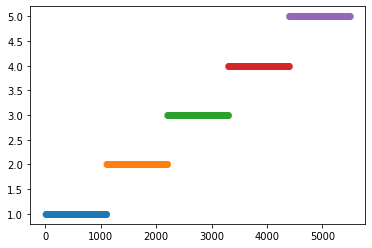

In [84]:
import matplotlib.pyplot as plt

kf = KFold(n_splits = 5, shuffle = False)
train_idx_store = []
valid_idx_store = []

i = 1
for train_idx, valid_idx in kf.split(train) :
  plt.scatter(valid_idx, [i for x in range(len(valid_idx))], alpha = 0.1)
  i += 1
plt.show()


## 아래의 이미지는 shuffle = False로 했을 때, 데이터가 겹치지 않게 순서대로 쪼개지는 것을 볼 수 있습니다.

## 실제 모델에 사용

In [95]:
x = onehot.drop(columns = ['index','quality'])
y = onehot['quality']

In [86]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 0) # kfold 지정

In [87]:
model = RandomForestClassifier(random_state = 0)
valid_scores = []
test_predictions = []

In [109]:
from sklearn.metrics import accuracy_score

for train_idx, valid_idx in kf.split(x,y) : 
  x_tr = x.iloc[train_idx]
  y_tr = y.iloc[train_idx]

  x_val = x.iloc[valid_idx]
  y_val = y.iloc[valid_idx]

  model.fit(x_tr, y_tr)
  valid_prediction = model.predict(x_val)
  score = accuracy_score(y_val, valid_prediction)
  valid_scores.append(score)

  test_prediction = model.predict(test.drop(columns = ['index']))
  test_predictions.append(test_prediction)
  
print('평균 점수 : ', np.mean(valid_scores))

test_predictions = pd.DataFrame(test_predictions)
test_predictions

평균 점수 :  0.6750508130081301


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,6.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,7.0,6.0,6.0,5.0,6.0,6.0
1,6.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0
2,6.0,5.0,6.0,5.0,6.0,6.0,6.0,6.0,6.0,7.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0
3,6.0,5.0,6.0,5.0,6.0,6.0,5.0,6.0,6.0,7.0,...,6.0,6.0,6.0,6.0,7.0,5.0,6.0,5.0,6.0,6.0
4,6.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,5.0,6.0,6.0,6.0,5.0,6.0,6.0
5,6.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,7.0,6.0,6.0,5.0,6.0,6.0
6,6.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0
7,6.0,5.0,6.0,5.0,6.0,6.0,6.0,6.0,6.0,7.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0
8,6.0,5.0,6.0,5.0,6.0,6.0,5.0,6.0,6.0,7.0,...,6.0,6.0,6.0,6.0,7.0,5.0,6.0,5.0,6.0,6.0
9,6.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,5.0,6.0,6.0,6.0,5.0,6.0,6.0


In [ ]:
test_prediction = test_predictions.mode() # 열별 최빈값 확인
test_prediction = test_prediction.values[0]
test_prediction

In [111]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['quality'] = test_prediction
sample_submission

,index,quality
0,0,6.0
1,1,5.0
2,2,6.0
3,3,5.0
4,4,6.0
...,...,...
995,995,6.0
996,996,6.0
997,997,5.0
998,998,6.0


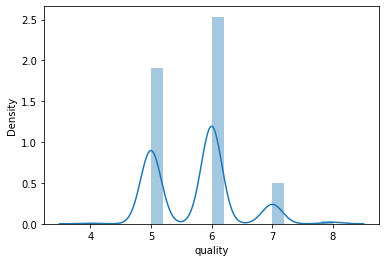

In [113]:
sns.distplot(sample_submission['quality'])